In [1]:
import numpy as np
import pandas as pd
import itertools
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.framework import ops
from tensorflow.python.saved_model import loader
from tensorflow.python.saved_model import tag_constants
from tensorflow.python.util import compat
df = pd.read_csv("../loan_final313.csv", low_memory=False)
from keras.models import Sequential
from keras.layers import Dense

/Users/janson/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/janson/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/janson/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/janson/opt/anaconda3/lib/python3.7/site-packages/tensorflow/

In [2]:
df.head()

,id,year,issue_d,final_d,emp_length_int,home_ownership,home_ownership_cat,income_category,annual_inc,income_cat,...,loan_condition_cat,interest_rate,grade,grade_cat,dti,total_pymnt,total_rec_prncp,recoveries,installment,region
0,1077501,2011,01/12/2011,1012015,10.0,RENT,1,Low,24000,1,...,0,10.65,B,2,27.65,5861.071414,5000.00,0.00,162.87,munster
1,1077430,2011,01/12/2011,1042013,0.5,RENT,1,Low,30000,1,...,1,15.27,C,3,1.00,1008.710000,456.46,117.08,59.83,leinster
2,1077175,2011,01/12/2011,1062014,10.0,RENT,1,Low,12252,1,...,0,15.96,C,3,8.72,3003.653644,2400.00,0.00,84.33,cannught
3,1076863,2011,01/12/2011,1012015,10.0,RENT,1,Low,49200,1,...,0,13.49,C,3,20.00,12226.302210,10000.00,0.00,339.31,ulster
4,1075358,2011,01/12/2011,1012016,1.0,RENT,1,Low,80000,1,...,0,12.69,B,2,17.94,3242.170000,2233.10,0.00,67.79,ulster


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 30 columns):
id                      887379 non-null int64
year                    887379 non-null int64
issue_d                 887379 non-null object
final_d                 887379 non-null int64
emp_length_int          887379 non-null float64
home_ownership          887379 non-null object
home_ownership_cat      887379 non-null int64
income_category         887379 non-null object
annual_inc              887379 non-null int64
income_cat              887379 non-null int64
loan_amount             887379 non-null int64
term                    887379 non-null object
term_cat                887379 non-null int64
application_type        887379 non-null object
application_type_cat    887379 non-null int64
purpose                 887379 non-null object
purpose_cat             887379 non-null int64
interest_payments       887379 non-null object
interest_payment_cat    887379 non-null int64
loan_c

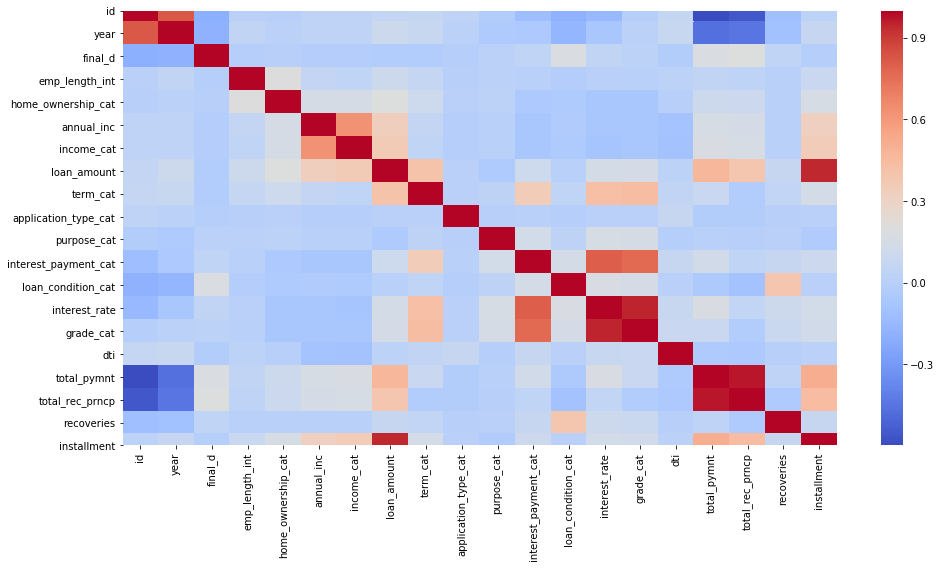

In [4]:
plt.figure(figsize=(16,8))
sns.heatmap(df.corr(), cmap = 'coolwarm')

Function to create a new column for independent variable

In [5]:
def defaulted(x):
    if x == 'Good Loan':
        return 0
    else:
        return 1

In [6]:
df['default'] = df['loan_condition'].apply(lambda x: defaulted(x))

Exploratory Data Analysis

After scanning through the data, the following columns can be dropped from the df since they will not be essential in predicting the final output.

id : Identification number for each individual <br> 
year: Year the loan was issued <br> 
issue_d: Issue Date <br> 
final_d: Final Date <br> 
application_type & application_type_cat : Individual or Joint <br> 
loan_condition & loan_condition_cat: already converted to 'default' <br> 
grade & grade_cat: Loan grade<br> 
total_pymt: total payment<br> 
total_rec_prncp: total recovered principal<br> 
recoveries: recoveries<br> 
installment: installment<br> 
region: region<br> 

In [7]:
df.drop(['grade', 'grade_cat', 'id', 'year', 'issue_d', 'final_d', 'application_type',
        'application_type_cat', 'loan_condition', 'loan_condition_cat', 
         'total_pymnt', 'total_rec_prncp', 'recoveries', 'installment', 'region'],axis=1,inplace=True)

In [8]:
# emp_length_int: Employment length in years
# Scale to 0 -> 1
scaler = MinMaxScaler()
df['emp_length_int'] = scaler.fit_transform(df['emp_length_int'].values.reshape(-1,1))

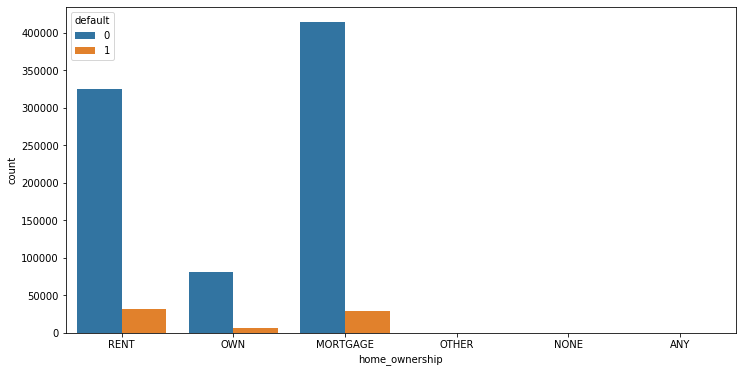

In [9]:
#home_ownership: Home Owndership status --> One-hot encode
plt.figure(figsize=(12,6))
sns.countplot(x='home_ownership',data=df, hue='default')

Since we can see that there are no borrowers in 'OTHER', 'NONE' and 'ANY', drop them

In [10]:
df = pd.concat([df, pd.get_dummies(df['home_ownership'])],
               axis=1).drop(['home_ownership', 'home_ownership_cat'],axis=1)

df.drop(['OTHER', 'NONE', 'ANY'],axis=1,inplace=True)

In [11]:
#income_category: Low, Medium, or High
df = pd.concat([df, pd.get_dummies(df['income_category'])],
               axis=1).drop(['income_category', 'income_cat'],axis=1)

In [12]:
#annual_inc Scale to 0 -> 1
df['annual_inc'] = scaler.fit_transform(df['annual_inc'].values.reshape(-1,1))

In [13]:
#loan_amount Scale to 0 -> 1
df['loan_amount'] = scaler.fit_transform(df['loan_amount'].values.reshape(-1,1))

In [14]:
# term: Length of the loan
df['term'].unique()

array([' 36 months', ' 60 months'], dtype=object)

In [15]:
#one-hot encode
df = pd.concat([df, pd.get_dummies(df['term_cat'],prefix='term')],
               axis=1).drop(['term', 'term_cat'],axis=1)

In [16]:
# purpose: Reason for issuing loan
df['purpose'].unique()

array(['credit_card', 'car', 'small_business', 'other', 'wedding',
       'debt_consolidation', 'home_improvement', 'major_purchase',
       'medical', 'moving', 'vacation', 'house', 'renewable_energy',
       'educational'], dtype=object)

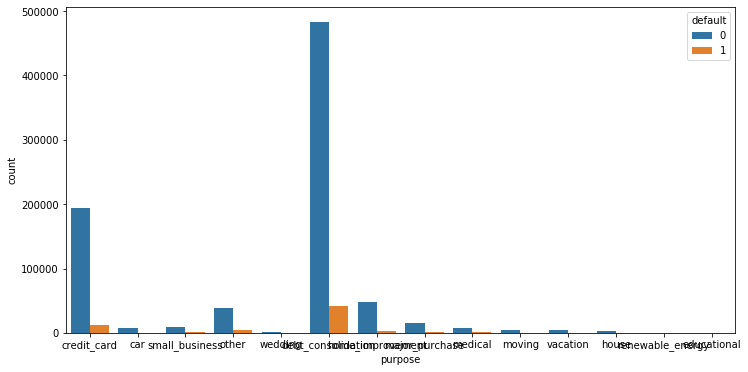

In [17]:
plt.figure(figsize=(12,6))
sns.countplot(x='purpose',data=df, hue='default')


In [18]:
#remove those variables that are skewed/ have little entries

In [19]:
df = pd.concat([df, pd.get_dummies(df['purpose'])],
               axis=1).drop(['purpose', 'purpose_cat'],axis=1)

df.drop(['car', 'small_business', 'other', 'wedding', 'home_improvement', 'major_purchase',
       'medical', 'moving', 'vacation', 'house', 'renewable_energy',
       'educational'],axis=1, inplace=True)

In [20]:
# interest_payments: Low or High
df = pd.concat([df, pd.get_dummies(df['interest_payments'],prefix='int')],
               axis=1).drop(['interest_payments', 'interest_payment_cat'],axis=1)

df.drop('int_High',axis=1,inplace=True)

In [21]:
# interest rate -> scale 0-1
df['interest_rate'] = scaler.fit_transform(df['interest_rate'].values.reshape(-1,1))

In [22]:
# dti: Ratio of monthly debt payments to annual income scale to 0 -> 1
df['dti'] = scaler.fit_transform(df['dti'].values.reshape(-1,1))

In [23]:
#Final df to be used:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 887379 entries, 0 to 887378
Data columns (total 17 columns):
emp_length_int        887379 non-null float64
annual_inc            887379 non-null float64
loan_amount           887379 non-null float64
interest_rate         887379 non-null float64
dti                   887379 non-null float64
default               887379 non-null int64
MORTGAGE              887379 non-null uint8
OWN                   887379 non-null uint8
RENT                  887379 non-null uint8
High                  887379 non-null uint8
Low                   887379 non-null uint8
Medium                887379 non-null uint8
term_1                887379 non-null uint8
term_2                887379 non-null uint8
credit_card           887379 non-null uint8
debt_consolidation    887379 non-null uint8
int_Low               887379 non-null uint8
dtypes: float64(5), int64(1), uint8(11)
memory usage: 49.9 MB


## Train Test Split

In [24]:
X = df.drop('default',axis=1)
y = df['default']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=100)

In [25]:
FEATURES = ['debt_consolidation','emp_length_int', 'annual_inc', 
            'loan_amount', 'interest_rate', 'dti', 'MORTGAGE', 'OWN', 'RENT', 'High',
            'Low', 'Medium', 'term_1', 'term_2', 'credit_card', 'debt_consolidation', 
            'int_Low'] 

COLUMNS = ['debt_consolidation','emp_length_int', 'annual_inc', 
            'loan_amount', 'interest_rate', 'dti', 'MORTGAGE', 'OWN', 'RENT', 'High',
            'Low', 'Medium', 'term_1', 'term_2', 'credit_card', 'debt_consolidation', 
            'int_Low', 'default'] 

LABEL = 'default'

In [29]:
model = Sequential()
model.add(Dense(12, input_dim=16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [30]:
from keras.callbacks import EarlyStopping
early_stopping_monitor = EarlyStopping(patience=3)

model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mse'])

model.fit(X_train, y_train, epochs=20, batch_size=10, callbacks=[early_stopping_monitor])

Epoch 1/20
709903/709903 [==============================] - 173s 244us/step - loss: 0.0681 - mae: 0.1360 - mse: 0.0681
Epoch 2/20
   560/709903 [..............................] - ETA: 3:25 - loss: 0.0667 - mae: 0.1359 - mse: 0.0667  

/Users/janson/opt/anaconda3/lib/python3.7/site-packages/keras/callbacks/callbacks.py:846: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss,mae,mse
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


709903/709903 [==============================] - 150s 211us/step - loss: 0.0677 - mae: 0.1353 - mse: 0.0677
Epoch 3/20
709903/709903 [==============================] - 154s 217us/step - loss: 0.0676 - mae: 0.1350 - mse: 0.0676
Epoch 4/20
709903/709903 [==============================] - 151s 213us/step - loss: 0.0676 - mae: 0.1351 - mse: 0.0676
Epoch 5/20
709903/709903 [==============================] - 141s 199us/step - loss: 0.0676 - mae: 0.1350 - mse: 0.0676
Epoch 6/20
709903/709903 [==============================] - 141s 199us/step - loss: 0.0676 - mae: 0.1351 - mse: 0.0676
Epoch 7/20
709903/709903 [==============================] - 143s 202us/step - loss: 0.0676 - mae: 0.1349 - mse: 0.0676
Epoch 8/20
709903/709903 [==============================] - 141s 198us/step - loss: 0.0675 - mae: 0.1349 - mse: 0.0675
Epoch 9/20
709903/709903 [==============================] - 140s 197us/step - loss: 0.0676 - mae: 0.1349 - mse: 0.0676
Epoch 10/20
709903/709903 [==============================] 

In [42]:
score = model.evaluate(X_test, y_test, batch_size=128)

177476/177476 [==============================] - 2s 9us/step


In [45]:
print(model.metrics_names)
print(score)

['loss', 'mae', 'mse']
[0.06847739073370912, 0.14091220498085022, 0.06847744435071945]


In [ ]:
# from sklearn.metrics import accuracy_score
# accuracy = accuracy_score(y_test, y_pred)
# print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [47]:
import pickle
filename = 'SNN.pkl'
pickle.dump(model, open(filename, 'wb'))